<a href="https://colab.research.google.com/github/rickituri98/Fault_Classifier_CNN/blob/master/CNN_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Validación Herramienta Computacional - IEEE 13 Node Test Feeder

In [ ]:
!npx degit rickituri98/Fault_Classifier_CNN -f

npx: installed 1 in 1.935s
> destination directory is not empty. Using --force, continuing
> cloned rickituri98/Fault_Classifier_CNN#master


## Importación de Trabajo de Preprocesamiento y Entrenamiento

In [ ]:
from data_handling import import_files, creacion_dic, time_event, sag_detector
from data_handling import swell_detector, event_result, find_nearest, DWT_Level_N
from comtrade import Comtrade
import scipy.io as sio
import copy
import matplotlib.pyplot as plt
import time
import os
import sys
import numpy as np
import pickle
from scipy.signal import find_peaks
import pywt
import tensorflow as tf
from tensorflow import keras
import zipfile
from tabulate import tabulate
from keras.utils import to_categorical
with zipfile.ZipFile("/content/Outputs_Data_Handling/Training&Test_set.zip","r") as zip_ref:
    zip_ref.extractall()

with zipfile.ZipFile("/content/Outputs_Data_Handling/Comtrade_dict.zip","r") as zip_ref2:
    zip_ref2.extractall()

with open('/content/Comtrade_dict.pickle', 'rb') as handle:
    Comtrade_signals = pickle.load(handle)
signals_NOGD = Comtrade_signals.get('NOGD_signals')
signals_GD = Comtrade_signals.get('GD_signals')
print(len(signals_GD), type(signals_NOGD), len(signals_NOGD[0].get("time")))

with open('/content/Outputs_Data_Handling/Curves_Lines_NOGD.pickle', 'rb') as handle:
    Curv_Lines_NOGD = pickle.load(handle)
L692_NOGD_c = Curv_Lines_NOGD.get('L692_NOGD')
L632_NOGD_c = Curv_Lines_NOGD.get('L632_NOGD')
L684_NOGD_c = Curv_Lines_NOGD.get('L684_NOGD')
L645_NOGD_c = Curv_Lines_NOGD.get('L645_NOGD')

with open('/content/Outputs_Data_Handling/Curves_Lines_GD.pickle', 'rb') as handle:
    Curv_Lines_GD = pickle.load(handle)
L692_GD_c = Curv_Lines_GD.get('L692_GD')
L632_GD_c = Curv_Lines_GD.get('L632_GD')
L684_GD_c = Curv_Lines_GD.get('L684_GD')
L645_GD_c = Curv_Lines_GD.get('L645_GD')
print(len(L692_NOGD_c), len(L692_GD_c))

with open('/content/Outputs_Data_Handling/Test_dict.pickle', 'rb') as handle:
    Test_set = pickle.load(handle)
X_test_set = Test_set.get('X_test')
Y_test_set = Test_set.get('Y_test')
X_test_id = Test_set.get('X_test_filenames')
print(len(X_test_set), len(Y_test_set))

with open('/content/Outputs_Data_Handling/Fault_Categories.pickle', 'rb') as handle:
    Faults_Cat = pickle.load(handle)
ph3_faults_set = Faults_Cat.get('3ph-faults')
ph2_faults_set = Faults_Cat.get('2ph-faults')
ph2g_faults_set = Faults_Cat.get('2phG-faults')
ph1_faults_set = Faults_Cat.get('1ph-faults')
print(len(ph3_faults_set), type(ph3_faults_set))

TrainTest_dict = sio.loadmat('/content/Training&Test_set.mat')
X_testset = TrainTest_dict.get("X_test")
Y_testset = TrainTest_dict.get("Y_test")
Y_testset = Y_testset.reshape((len(Y_testset),))
Y_testvalues = np.array(Y_testset)
Y_onehot_test = to_categorical(Y_testvalues)
print(type(X_testset), len(X_testset), X_testset.shape)

336 <class 'list'> 3001
4 4
201 201
14 <class 'list'>
<class 'numpy.ndarray'> 201 (201, 2943, 3)


In [ ]:
# Recreation of trained Fault classifier model, including its weights and the optimizer
trained_model = tf.keras.models.load_model('/content/Trained_Model_Files/Fault_Classifier_model.h5')

# Show the model architecture
trained_model.summary()

# Verification
loss, acc, mse, mae = trained_model.evaluate(X_testset, Y_onehot_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

Model: "Fault_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 2943, 3)]         0         
_________________________________________________________________
conv0 (Conv1D)               (None, 2943, 18)          126       
_________________________________________________________________
pool0 (MaxPooling1D)         (None, 1472, 18)          0         
_________________________________________________________________
conv1 (Conv1D)               (None, 1472, 36)          1332      
_________________________________________________________________
pool1 (MaxPooling1D)         (None, 736, 36)           0         
_________________________________________________________________
conv2 (Conv1D)               (None, 736, 72)           5256      
_________________________________________________________________
pool2 (MaxPooling1D)         (None, 368, 72)      

## Procesamiento Archivos Comtrade
La estructura de los archivos comtrade corresponde a las lecturas de tensión por fase en unidades físicas (kV). Por lo cual, la selección del evento reflejara una gráfica ilustrativa




In [ ]:
def read_comtrade(path, filename):
  rec_event = Comtrade()
  rec_event.load(path+filename)
  num_sig = rec_event.analog_count
  timesec = np.array(rec_event.time)
  samples =rec_event.total_samples
  dic=dict.fromkeys(['A','B','C'],np.zeros(samples))
  dic['time']=timesec
  for k in range(0, num_sig):
    string = rec_event.analog_channel_ids[k]
    creacion_dic(dic,rec_event.analog[k],string)
  return dic

def Visualize_event(num, sig_list, Inputs_signals, inputs_id):
  sig = [item[1] for item in sig_list if item[0] == num]
  #sample = read_comtrade(path, sig[0])
  sample = Inputs_signals[sig[0][0]]
  plt.figure(figsize=(15,8))
  plt.plot(1000*sample.get("time"), sample.get("A"))
  plt.plot(1000*sample.get("time"), sample.get("B"))
  plt.plot(1000*sample.get("time"), sample.get("C"))
  plt.legend(["Fase A", "Fase B", "Fase C"])
  plt.xlabel("Tiempo (ms)")
  plt.ylabel("Voltaje (kV)")
  plt.grid()
  plt.title('Evento:'+inputs_id[sig[0][0]])
  plt.show()
  return sample, sig[0][0]

pos_vect = np.random.randint(len(X_test_set)-1, size=15)
print(pos_vect, pos_vect[-4])
select_list = list((i+1, X_test_id[pos_vect[i]]) for i in range(len(pos_vect)))
id_list = list((j+1, [pos_vect[j]]) for j in range(len(pos_vect)))
print(id_list[1], X_test_id[pos_vect[1]])


[ 95  48 184 107 194  35 156  80  38 164 148   7   6  15  84] 7
(2, [48]) Osc L632-633_95%_Falla 1ph_NOGD.cfg


## Seleccione el evento de la tabla escribiendo el número asociado
Estos eventos son recuperados de forma aleatoria del conjunto de prueba que se obtuvo en el notebook: Data Handling

  Number  Event
--------  ------------------------------------
       1  Osc L684-652_20%_Falla 1ph_NOGD.cfg
       2  Osc L632-633_95%_Falla 1ph_NOGD.cfg
       3  Osc L645-646_20%_Falla 2phG_GD.cfg
       4  Osc L632-633_70%_Falla 2ph_GD.cfg
       5  Osc L692-675_20%_Falla 1ph_GD.cfg
       6  Osc L692-675_65%_Falla 3ph_NOGD.cfg
       7  Osc L684-652_95%_Sin falla_GD.cfg
       8  Osc L684-652_80%_Falla 1ph_NOGD.cfg
       9  Osc L684-652_05%_Falla 1ph_NOGD.cfg
      10  Osc L692-675_75%_Falla 1ph_GD.cfg
      11  Osc L692-675_05%_Falla 1ph_GD.cfg
      12  Osc L632-633_70%_Falla 2phG_NOGD.cfg
      13  Osc L692-675_70%_Falla 2phG_NOGD.cfg
      14  Osc L692-675_10%_Falla 1ph_NOGD.cfg
      15  Osc L632-633_60%_Falla 3ph_NOGD.cfg
Introduzca la señal que quiere evaluar:3


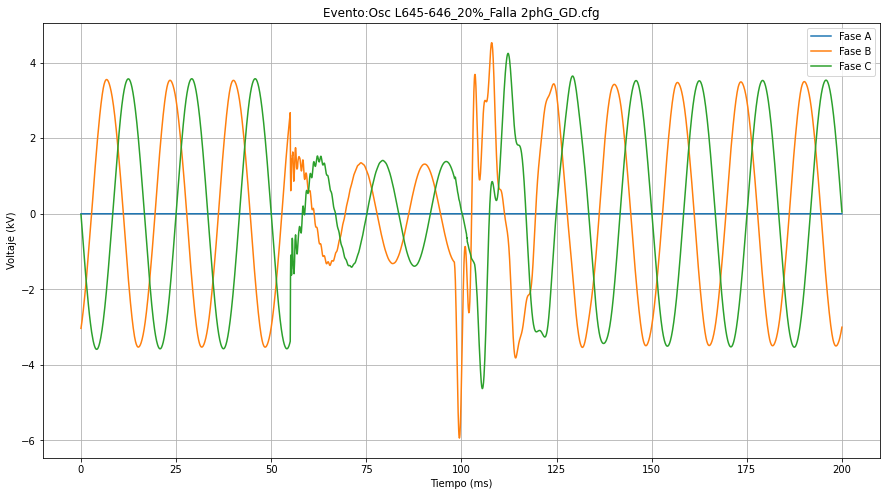

In [ ]:
print(tabulate(select_list, headers = ['Number', 'Event']))
num = input('Introduzca la señal que quiere evaluar:')
fault_event, index = Visualize_event(int(num), id_list, X_test_set, X_test_id)

## Evaluación del evento por parte del modelo CNN

In [ ]:
def fault_location(pred_str, mag, ind):
  line = X_test_id[ind]
  stno = line.find('NO')
  if stno != -1:
    line = line[line.find('L'):line.find('L')+8]
    if line == 'L632-633':
      loc = find_nearest(L632_NOGD_c.get(pred_str), mag)
    elif line == 'L692-675':
      loc = find_nearest(L692_NOGD_c.get(pred_str), mag)
    elif line == 'L645-646':
      loc = find_nearest(L645_NOGD_c.get(pred_str), mag)
    elif line == 'L684-652':
      loc = find_nearest(L645_NOGD_c.get(pred_str), mag)
  else:
    line = line[line.find('L'):line.find('L')+8]
    if line == 'L632-633':
      loc = find_nearest(L632_GD_c.get(pred_str), mag)
    elif line == 'L692-675':
      loc = find_nearest(L692_GD_c.get(pred_str), mag)
    elif line == 'L645-646':
      loc = find_nearest(L645_GD_c.get(pred_str), mag)
    elif line == 'L684-652':
      loc = find_nearest(L645_GD_c.get(pred_str), mag)
  return 'Localización aproximada de la falla en '+ str(loc) + '%'

In [ ]:
def pred_event(model, event_dwt, X_test_pre,ind):
  s_event = X_test_pre[ind]
  t_sec = s_event.get('time')
  coeffsa = pywt.wavedec(s_event.get("A"), 'bior4.4', level=5)
  coeffsb = pywt.wavedec(s_event.get("B"), 'bior4.4', level=5)
  coeffsc = pywt.wavedec(s_event.get("C"), 'bior4.4', level=5)
  tdurA, magA, type_A = event_result(coeffsa[0], t_sec)
  tdurB, magB, type_B = event_result(coeffsb[0], t_sec)
  tdurC, magC, type_C = event_result(coeffsc[0], t_sec)
  mags = 100*np.sort([magA, magB, magC])
  durs = [tdurA, tdurB, tdurC]
  inds = np.argsort([magA, magB, magC])
  ph = ['A', 'B', 'C']
  #print(mags, inds)
  Y_onehot_pred = model.predict(event_dwt)
  pred = np.argmax(Y_onehot_pred[ind])
  if pred == 0:
    if mags[0] == 0:
      mag = np.round(mags[1], 3)
      dur = np.round(1000*np.min([durs[inds[1]], durs[inds[2]]]), 3)
      f_ph = [ph[inds[1]], ph[inds[2]]]
      msg = '\033[1m' +'REPORTE DEL EVENTO:'+'\n'+'\033[0m'+"FALLA MONOFÁSICA DETECTADA EN FASE "+ f_ph[0]
      msg += '\n'+'Y Swell en la fase '+ f_ph[1] + ' con magnitud de ' + str(np.round(mags[2],3)) + '%'      
    else:
      mag = np.round(mags[0], 3)
      swell = np.round(np.mean([mags[1], mags[2]]), 3)
      dur = np.round(1000*np.min([tdurA, tdurB, tdurC]), 3)
      msg = '\033[1m' +'REPORTE DEL EVENTO:'+'\n'+'\033[0m'+"FALLA MONOFÁSICA DETECTADA EN FASE "+ ph[inds[0]]
      msg += '\n'+'Swell en fases '+ ph[inds[1]] + ', ' + ph[inds[2]] + ' con magnitud de '+ str(swell) + '%'
    msg += '\n'+"Magnitud del sag:" +str(mag)
    msg += '% \n' + 'Duración:' + str(dur) + 'ms'
    loc_str = fault_location('1-ph', mag, ind)
    msg += '\n' + loc_str
  elif pred == 1:
    if mags[0] == 0:
      mag = np.round(np.mean([mags[1], mags[2]]), 3)
      dur = np.round(1000*np.min([durs[inds[1]], durs[inds[2]]]), 3)
      f_ph = [ph[inds[1]], ph[inds[2]]]
      msg = '\033[1m' +'REPORTE DEL EVENTO:'+'\n'+'\033[0m'+"FALLA BIFÁSICA DETECTADA EN FASES "+ f_ph[0]+' Y '+ f_ph[1]
    else:
      mag = np.round(np.mean([mags[0], mags[1]]), 3)
      dur = np.round(1000*np.min([tdurA, tdurB, tdurC]), 3)
      f_ph = [ph[inds[0]], ph[inds[1]]]
      msg = '\033[1m' +'REPORTE DEL EVENTO:'+'\n'+'\033[0m'+"FALLA BIFÁSICA DETECTADA EN FASES "+ f_ph[0]+' Y '+ f_ph[1]
      msg += '\n'+'Swell en fase '+ ph[inds[2]] + ' de magnitud '+ str(np.round(mags[2],3)) + '%'
    msg += '\n'+"Magnitud del sag:" +str(mag)
    msg += '% \n' + 'Duración:' + str(dur) + 'ms'
    loc_str = fault_location('2-ph', mag, ind)
    msg += '\n' + loc_str
  elif pred == 2:
    if mags[0] == 0:
      mag = np.round(np.mean([mags[1], mags[2]]), 3)
      dur = np.round(1000*np.min([durs[inds[1]], durs[inds[2]]]), 3)
      f_ph = [ph[inds[1]], ph[inds[2]]]
      msg = '\033[1m' +'REPORTE DEL EVENTO:'+'\n'+'\033[0m'+"FALLA BIFÁSICA A TIERRA DETECTADA EN FASES "+ f_ph[0]+' Y '+ f_ph[1]
    else:
      mag = np.round(np.mean([mags[0], mags[1]]), 3)
      dur = np.round(1000*np.min([tdurA, tdurB, tdurC]), 3)
      f_ph = [ph[inds[0]], ph[inds[1]]]
      msg = '\033[1m' +'REPORTE DEL EVENTO:'+'\n'+'\033[0m'+"FALLA BIFÁSICA A TIERRA DETECTADA EN FASES "+ f_ph[0]+' Y '+ f_ph[1]
      msg += '\n'+'Swell en fase '+ ph[inds[2]] + ' Y magnitud de '+ str(np.round(mags[2],3)) + '%'
    msg += '\n'+"Magnitud del sag:" +str(mag)
    msg += '% \n' + 'Duración:' + str(dur) + 'ms'
    loc_str = fault_location('2-phG', mag, ind)
    msg += '\n' + loc_str
  elif pred == 3:
    mag = np.round(np.mean([magA,magB,magC])*100, 3)
    dur = np.round(1000*np.min([tdurA, tdurB, tdurC]), 3)
    #loc = find_nearest(L632_GD_c.get('3-ph'), mag)
    msg = '\033[1m' +'REPORTE DEL EVENTO:'+'\n'+'\033[0m'+"FALLA TRIFÁSICA DETECTADA"
    msg += '\n'+"Magnitud del sag:" +str(mag)
    msg += '% \n' + 'Duración:' + str(dur)
    loc_str = fault_location('3-ph', mag, ind)
    msg += '\n' + loc_str
    #msg += 'ms \n' + 'Localización aproximada:' + str(loc)
    #msg += '% \n' + '\033[1m'+'FIN DEL REPORTE'   
  elif pred == 4:
    msg = '\033[1m' +'REPORTE DEL EVENTO:'+'\n'+'\033[0m'+"EVENTO EN CONDICIÓN NORMAL O LIGERA ELEVACIÓN DE TENSIÓN"
    mag = 0
  msg += '\n' + '\033[1m'+'FIN DEL REPORTE'   
  print(msg)
  #print('Estado de las fases: duración del evento || Magnitud || Es Sag?')
  #print("A", np.round(tdurA*1000, 3), 'ms ||', np.round(magA*100, 3), '% ||', type_A)
  #print("B", np.round(tdurB*1000, 3), 'ms ||', np.round(magB*100, 3), '% ||', type_B)
  #print("C", np.round(tdurC*1000, 3), 'ms ||', np.round(magC*100, 3), '% ||', type_C)
  return pred

#pred_event(trained_model, X_testset, X_test_set, index)
#print('intento 2',np.round(trained_model.predict(X_testset)[index]))




##Reporte de texto del evento

In [ ]:
pred_event(trained_model, X_testset, X_test_set, index)

REPORTE DEL EVENTO:
FALLA BIFÁSICA A TIERRA DETECTADA EN FASES B Y C
Magnitud del sag:37.052% 
Duración:45.098ms
Localización aproximada de la falla en 4%
FIN DEL REPORTE


2

## Comparativa de eventos con GD y sin GD - Señales de tensión de fase

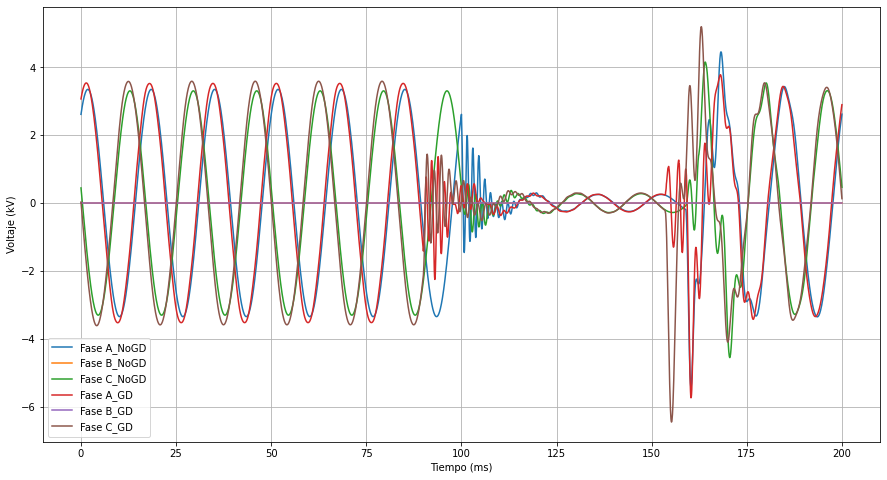

In [ ]:
num_ev = input('Introduzca un número de 0 a 335 y obtendra una oscilografía comparativa:')
num_ev =int(num_ev)
plt.figure(figsize=(15,8))
plt.plot(1000*signals_NOGD[2].get("time"), signals_NOGD[num_ev].get("A"))
plt.plot(1000*signals_NOGD[2].get("time"), signals_NOGD[num_ev].get("B"))
plt.plot(1000*signals_NOGD[2].get("time"), signals_NOGD[num_ev].get("C"))
plt.plot(1000*signals_GD[2].get("time"), signals_GD[num_ev].get("A"))
plt.plot(1000*signals_GD[2].get("time"), signals_GD[num_ev].get("B"))
plt.plot(1000*signals_GD[2].get("time"), signals_GD[num_ev].get("C"))
plt.legend(["Fase A_NoGD", "Fase B_NoGD", "Fase C_NoGD", "Fase A_GD", "Fase B_GD", "Fase C_GD"])
plt.xlabel("Tiempo (ms)")
plt.ylabel("Voltaje (kV)")
plt.grid()
plt.show()

## Caracterización de líneas: Curvas de Magnitud vs Distancia (%)

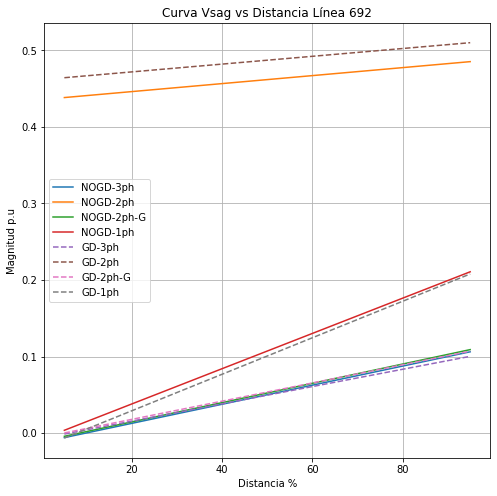

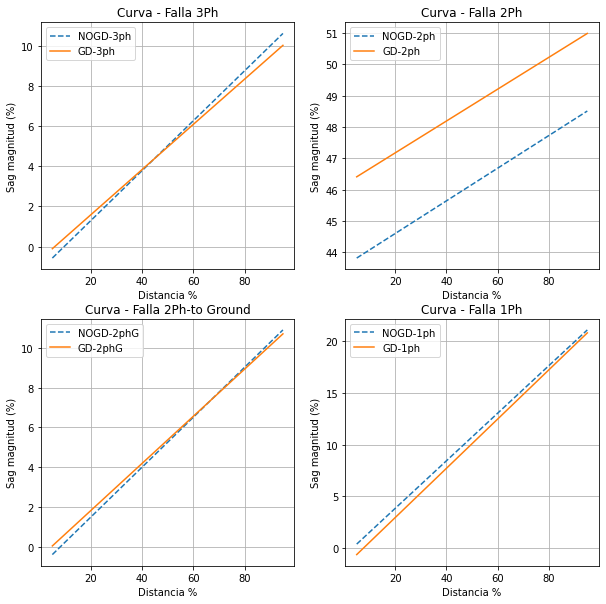

In [ ]:
## Linea 692
def Curve_B692():
  plt.figure(figsize=(10,10))
  plt.subplot(2, 2, 1)
  plt.plot(L692_NOGD_c.get('3-ph')[0], 100*L692_NOGD_c.get('3-ph')[1], '--')
  plt.plot(L692_GD_c.get('3-ph')[0], 100*L692_GD_c.get('3-ph')[1])
  plt.title('Curva - Falla 3Ph')
  plt.xlabel("Distancia %")
  plt.ylabel("Sag magnitud (%)")
  plt.legend(['NOGD-3ph', 'GD-3ph'])
  plt.grid()
  plt.subplot(2, 2, 2)
  plt.plot(L692_NOGD_c.get('2-ph')[0], 100*L692_NOGD_c.get('2-ph')[1], '--')
  plt.plot(L692_GD_c.get('2-ph')[0], 100*L692_GD_c.get('2-ph')[1])
  plt.title('Curva - Falla 2Ph')
  plt.xlabel("Distancia %")
  plt.ylabel("Sag magnitud (%)")
  plt.legend(['NOGD-2ph', 'GD-2ph'])
  plt.grid()
  plt.subplot(2, 2, 3)
  plt.plot(L692_NOGD_c.get('2-phG')[0], 100*L692_NOGD_c.get('2-phG')[1], '--')
  plt.plot(L692_GD_c.get('2-phG')[0], 100*L692_GD_c.get('2-phG')[1])
  plt.title('Curva - Falla 2Ph-to Ground')
  plt.xlabel("Distancia %")
  plt.ylabel("Sag magnitud (%)")
  plt.legend(['NOGD-2phG', 'GD-2phG'])
  plt.grid()
  plt.subplot(2, 2, 4)
  plt.plot(L692_NOGD_c.get('1-ph')[0], 100*L692_NOGD_c.get('1-ph')[1], '--')
  plt.plot(L692_GD_c.get('1-ph')[0], 100*L692_GD_c.get('1-ph')[1])
  plt.title('Curva - Falla 1Ph')
  plt.xlabel("Distancia %")
  plt.ylabel("Sag magnitud (%)")
  plt.legend(['NOGD-1ph', 'GD-1ph'])
  plt.grid()
  plt.show
  plt.savefig('sag_curve_L692-675.png')


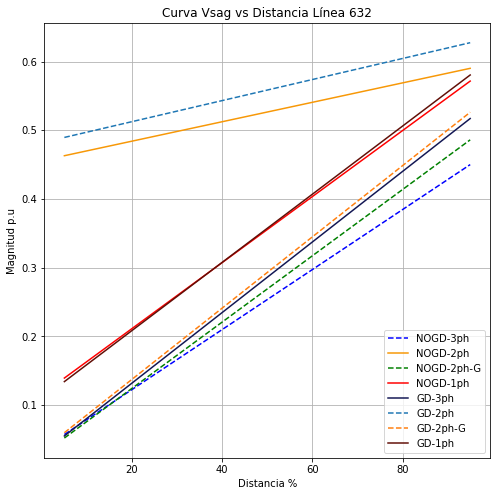

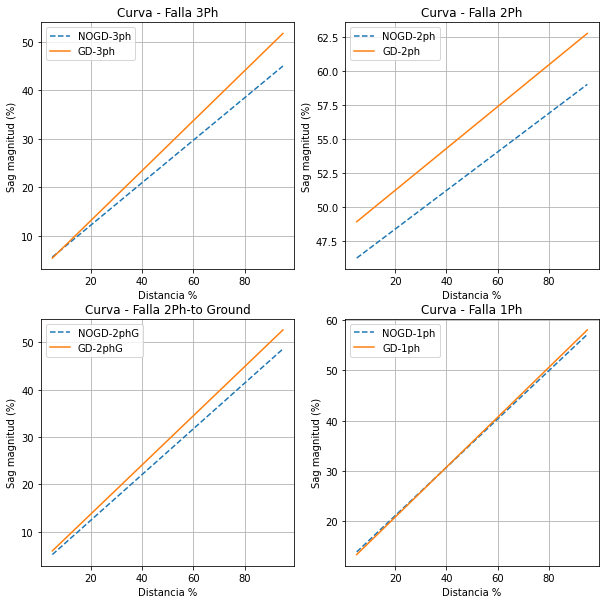

In [ ]:
## Linea 632
def curve_B632():  
  plt.figure(figsize=(10,10))
  plt.subplot(2, 2, 1)
  plt.plot(L632_NOGD_c.get('3-ph')[0], 100*L632_NOGD_c.get('3-ph')[1], '--')
  plt.plot(L632_GD_c.get('3-ph')[0], 100*L632_GD_c.get('3-ph')[1])
  plt.title('Curva - Falla 3Ph')
  plt.xlabel("Distancia %")
  plt.ylabel("Sag magnitud (%)")
  plt.legend(['NOGD-3ph', 'GD-3ph'])
  plt.grid()
  plt.subplot(2, 2, 2)
  plt.plot(L632_NOGD_c.get('2-ph')[0], 100*L632_NOGD_c.get('2-ph')[1], '--')
  plt.plot(L632_GD_c.get('2-ph')[0], 100*L632_GD_c.get('2-ph')[1])
  plt.title('Curva - Falla 2Ph')
  plt.xlabel("Distancia %")
  plt.ylabel("Sag magnitud (%)")
  plt.legend(['NOGD-2ph', 'GD-2ph'])
  plt.grid()
  plt.subplot(2, 2, 3)
  plt.plot(L632_NOGD_c.get('2-phG')[0], 100*L632_NOGD_c.get('2-phG')[1], '--')
  plt.plot(L632_GD_c.get('2-phG')[0], 100*L632_GD_c.get('2-phG')[1])
  plt.title('Curva - Falla 2Ph-to Ground')
  plt.xlabel("Distancia %")
  plt.ylabel("Sag magnitud (%)")
  plt.legend(['NOGD-2phG', 'GD-2phG'])
  plt.grid()
  plt.subplot(2, 2, 4)
  plt.plot(L632_NOGD_c.get('1-ph')[0], 100*L632_NOGD_c.get('1-ph')[1], '--')
  plt.plot(L632_GD_c.get('1-ph')[0], 100*L632_GD_c.get('1-ph')[1])
  plt.title('Curva - Falla 1Ph')
  plt.xlabel("Distancia %")
  plt.ylabel("Sag magnitud (%)")
  plt.legend(['NOGD-1ph', 'GD-1ph'])
  plt.grid()
  plt.show
  plt.savefig('sag_curve_L632-633.png')


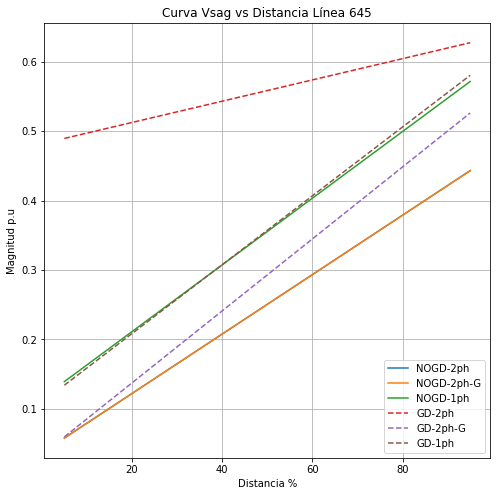

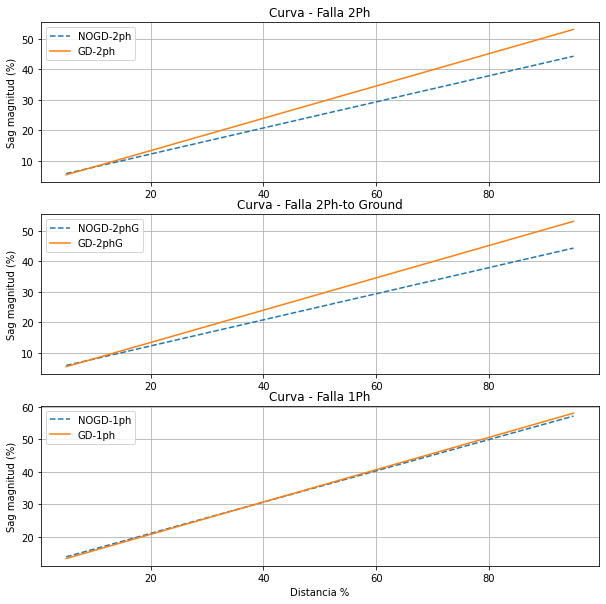

In [ ]:
## Linea 645
def curve_B645():  
  plt.figure(figsize=(10,10))
  plt.subplot(3, 1, 1)
  plt.plot(L645_NOGD_c.get('2-ph')[0], 100*L645_NOGD_c.get('2-ph')[1], '--')
  plt.plot(L645_GD_c.get('2-ph')[0], 100*L645_GD_c.get('2-ph')[1])
  plt.title('Curva - Falla 2Ph')
  plt.ylabel("Sag magnitud (%)")
  plt.legend(['NOGD-2ph', 'GD-2ph'])
  plt.grid()
  plt.subplot(3, 1, 2)
  plt.plot(L645_NOGD_c.get('2-phG')[0], 100*L645_NOGD_c.get('2-phG')[1], '--')
  plt.plot(L645_GD_c.get('2-phG')[0], 100*L645_GD_c.get('2-phG')[1])
  plt.title('Curva - Falla 2Ph-to Ground')
  plt.ylabel("Sag magnitud (%)")
  plt.legend(['NOGD-2phG', 'GD-2phG'])
  plt.grid()
  plt.subplot(3, 1, 3)
  plt.plot(L645_NOGD_c.get('1-ph')[0], 100*L645_NOGD_c.get('1-ph')[1], '--')
  plt.plot(L645_GD_c.get('1-ph')[0], 100*L645_GD_c.get('1-ph')[1])
  plt.title('Curva - Falla 1Ph')
  plt.xlabel("Distancia %")
  plt.ylabel("Sag magnitud (%)")
  plt.legend(['NOGD-1ph', 'GD-1ph'])
  plt.grid()
  plt.show
  plt.savefig('sag_curve_L645-646.png')


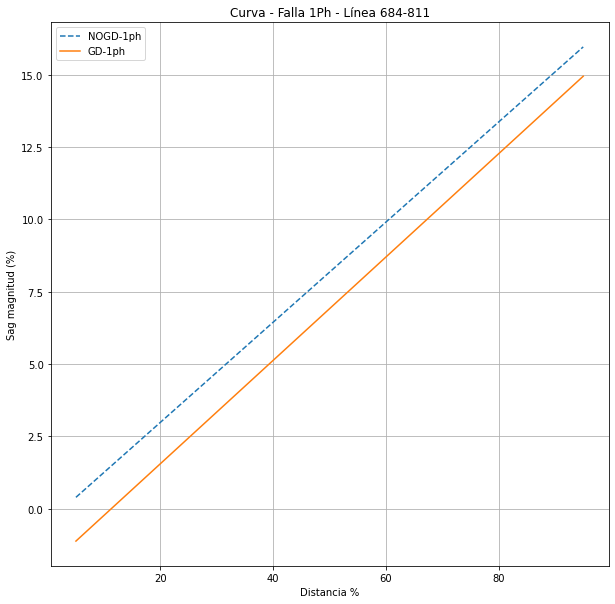

In [ ]:
## Linea 684
def curve_B684():
  plt.figure(figsize=(10,10))
  plt.plot(L684_NOGD_c.get('1-ph')[0], 100*L684_NOGD_c.get('1-ph')[1], '--')
  plt.plot(L684_GD_c.get('1-ph')[0], 100*L684_GD_c.get('1-ph')[1])
  plt.legend(['NOGD-1ph', 'GD-1ph'])
  plt.xlabel("Distancia %")
  plt.ylabel("Sag magnitud (%)")
  plt.title('Curva - Falla 1Ph - Línea 684-811')
  plt.grid()
  plt.show
  plt.savefig('sag_curve_L684-611.png')

## Gráficas - Curvas Características

### Bus 692

In [ ]:
curve_B692()

### Bus 632

In [ ]:
curve_B632()

### Bus 684

In [ ]:
curve_B684()

### Bus 645

In [ ]:
curve_B645()

## Mediciones de corriente GD vs NOGD (Nodos 633/634)
Se presentan gráficas comparativas del comportamiento de la corriente ante la presencia de tecnología de generación de energía basada en inversores. Los eventos son obtenidos a partir de una falla monofásica al 50% de la línea 632-633
 



In [ ]:
def comtrade_reader(path):
  rec_event = Comtrade()
  rec_event.load(path)
  num_sig = rec_event.analog_count
  timesec = np.array(rec_event.time)
  samples =rec_event.total_samples
  sig_ids = list()
  sig_values = list()
  for k in range(0, num_sig):
    sig_ids.append(rec_event.analog_channel_ids[k])
    sig_values.append(rec_event.analog[k])
  return sig_ids, sig_values, timesec

path_currents_NOGD = '/content/Events_Comtrade/Osc_L632-633_Currents/Oscilografía_L632-633_1PhF_CurrentsNOGD.cfg'
path_currents_GD = '/content/Events_Comtrade/Osc_L632-633_Currents/Oscilografía_L632-633_1PhF_CurrentsGD.cfg'

ids_nogd, values_nogd, _ = comtrade_reader(path_currents_NOGD)
ids_gd, values_gd, xtime = comtrade_reader(path_currents_GD)
xtime = xtime*1000
print(len(ids_nogd), len(ids_gd))
#for id in ids_nogd:
#  print(id)

def graph_bus633():  
  plt.figure(figsize=(15, 8))
  plt.subplot(2, 2, 1)
  plt.plot(xtime, values_nogd[3])
  plt.plot(xtime, values_nogd[4])
  plt.plot(xtime, values_nogd[5])
  plt.xlabel('tiempo (ms)')
  plt.title('Corrientes - Bus 633')
  plt.ylabel('Sin GD - Corriente (A)')
  plt.grid()
  plt.legend(['Fase A', 'Fase B', 'Fase C'])
  plt.subplot(2, 2, 3)
  plt.plot(xtime, values_gd[-8])
  plt.plot(xtime, values_gd[-9])
  plt.plot(xtime, values_gd[-7])
  plt.legend(['Fase A', 'Fase B', 'Fase C'])
  plt.xlabel('tiempo (ms)')
  plt.ylabel('Con GD - Corriente (A)')
  plt.grid()
  plt.subplot(2, 2, 2)
  plt.plot(xtime, values_nogd[0])
  plt.plot(xtime, values_nogd[1])
  plt.plot(xtime, values_nogd[2])
  plt.xlabel('tiempo (ms)')
  plt.title('Voltajes - Bus 633')
  plt.ylabel('Sin GD - Voltaje(kV)')
  plt.grid()
  plt.legend(['Fase A', 'Fase B', 'Fase C'])
  plt.subplot(2, 2, 4)
  plt.plot(xtime, values_gd[-3])
  plt.plot(xtime, values_gd[-2])
  plt.plot(xtime, values_gd[-1])
  plt.legend(['Fase A', 'Fase B', 'Fase C'])
  plt.xlabel('tiempo (ms)')
  plt.ylabel('Con GD - Voltaje(kV)')
  plt.grid()
  plt.savefig('Currents_Bus633.png')
  plt.show()
  

def graph_bus634():  
  plt.figure(figsize=(15, 8))
  plt.subplot(2, 1, 1)
  plt.plot(xtime, values_nogd[6]) # -1, -2, -3
  plt.plot(xtime, values_nogd[7])
  plt.plot(xtime, values_nogd[8])
  plt.xlabel('tiempo (ms)')
  plt.title('Corrientes - Bus 634')
  plt.ylabel('Sin GD - Corriente (A)')
  plt.grid()
  plt.legend(['Fase A', 'Fase B', 'Fase C'])
  plt.subplot(2, 1, 2)
  plt.plot(xtime, values_gd[0])
  plt.plot(xtime, values_gd[1])
  plt.plot(xtime, values_gd[2])
  plt.legend(['Fase A', 'Fase B', 'Fase C'])
  plt.xlabel('tiempo (ms)')
  plt.ylabel('Con GD - Corriente (A)')
  plt.grid()
  plt.savefig('Currents_Bus634.png')



15 21


/content/comtrade.py:298: Warning: Unknown standard revision "2000"
  warnings.warn(Warning(msg))


## Gráficas de Corriente Nodo 633 y 634

### Bus 633

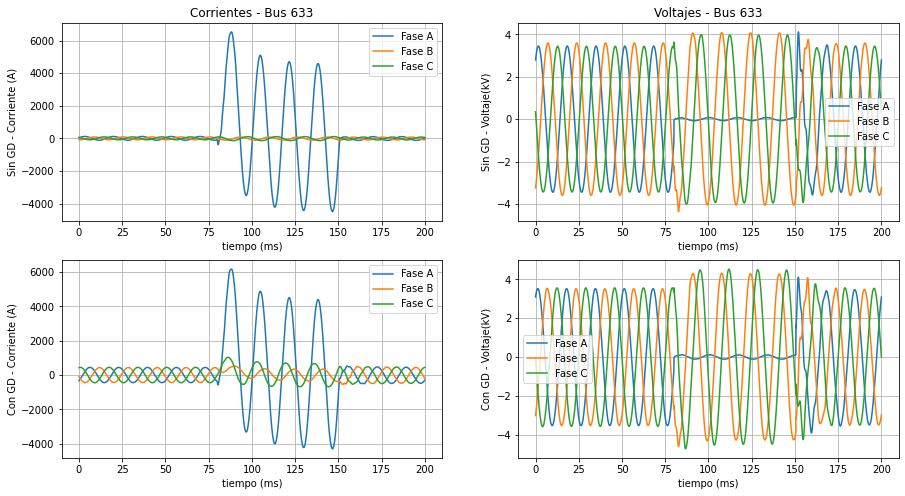

In [ ]:
graph_bus633()

### Bus 634

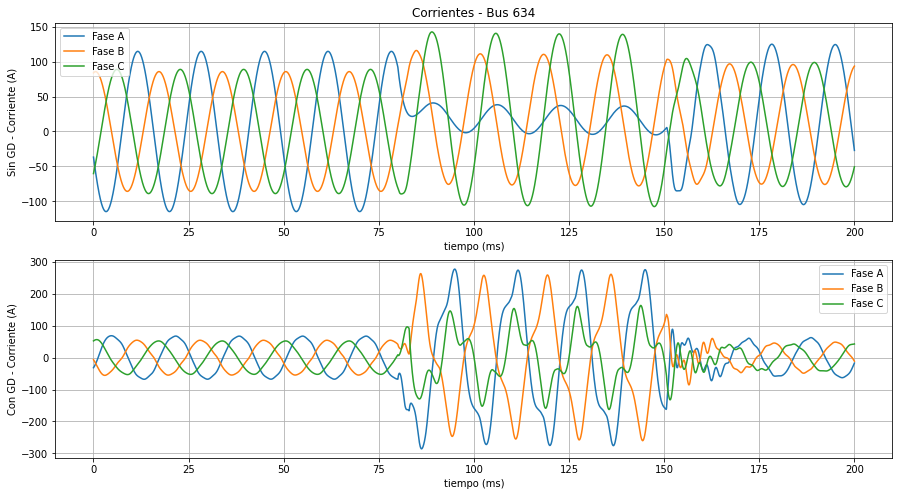

In [ ]:
graph_bus634()